In [2]:
from utils import *
import os
import numpy as np

Setup_environment()

from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose


# Define the path for the data_3d file
data_3d_path = 'data/intermedia/data_3d.npz'

# Check if the data_3d file exists
if os.path.exists(data_3d_path):
    # Load the data_3d if it exists
    loaded_data = np.load(data_3d_path)
    data_3d = loaded_data['data_3d']
else:
    # Your existing code to generate data_3d
    model_2D ='./detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
    weights_2D = './detectron/checkpoint/model_final_997cc7.pkl'
    model_3D = './VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

    pose2d = Wrapper_2Dpose(model=model_2D, weights=weights_2D, ROI_thr=0.75)
    pose_3d = Wrapper_3Dpose(model_3D)

    config = load_config()
    print(config['video_object'])

    video_object = Video_wrapper(config['video_object'], resize_video_by=0.3)
    data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
    data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)

    # Save the data_3d to an .npz file for future use
    np.savez(data_3d_path, data_3d=data_3d)

## Pose Optim  Loop

In [3]:
import torch
from ergonomics import RULA

def run_pose_optimization(original_pose, num_steps=3):
    """
    Optimize the pose using the RULA score.
    
    Parameters:
    - original_pose: A tensor of shape (17, 3)
    
    Returns:
    - Optimized pose.
    """
    #torch.autograd.set_detect_anomaly(True)


    for step in range(num_steps):


        rula_eval = RULA(original_pose)
        rula_score = rula_eval.compute_scores()

        
    return original_pose

optimized_pose = run_pose_optimization(data_3d)

p = optimized_pose.detach().numpy()
print('Original pose: ', data_3d[1,1,])
print('Optim pose: ', p[1,1,:])

--------------Frame: 0
Neck Angle:  35.15840067537411
Score Neck +1
Min knee: 9.806425431511144
Score Neck: 1
Score Trunk: 1
Score Legs: 1
Row: 0 Col: 0
--------------Frame: 1
Neck Angle:  35.741201761075274
Score Neck +1
Min knee: 10.381404416221159
Score Neck: 1
Score Trunk: 1
Score Legs: 1
Row: 0 Col: 0
--------------Frame: 2
Neck Angle:  36.0379648721721
Score Neck +1
Min knee: 10.661715379758476
Score Neck: 1
Score Trunk: 1
Score Legs: 1
Row: 0 Col: 0
--------------Frame: 3
Neck Angle:  36.364922810447695
Score Neck +1
Min knee: 10.76375840595847
Score Neck: 1
Score Trunk: 2
Score Legs: 1
Row: 0 Col: 2
--------------Frame: 4
Neck Angle:  36.73740441756891
Score Neck +1
Min knee: 10.996080460387276
Score Neck: 1
Score Trunk: 1
Score Legs: 1
Row: 0 Col: 0
--------------Frame: 5
Neck Angle:  37.239277176301414
Score Neck +1
Min knee: 11.254439195932179
Score Neck: 1
Score Trunk: 1
Score Legs: 1
Row: 0 Col: 0
--------------Frame: 6
Neck Angle:  37.84768309725146
Score Neck +1
Min knee

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
 sigmoid_45 = torch.sigmoid(-10 * 30+ 20)

# FAKE

In [9]:
#FAKEEEEEEfrom utils import *
import os
import numpy as np
from utils import Setup_environment
Setup_environment()
from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose
from torch.autograd import gradcheck
from FAKE import FAKE
import torch
import torch.optim as optim
import torch.nn as nn

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
data_3d_path = 'data/intermedia/data_3d.npz'
# Check if the data_3d file exists
if os.path.exists(data_3d_path):
    # Load the data_3d if it exists
    loaded_data = np.load(data_3d_path)
    data_3d = loaded_data['data_3d']
else:
    model_2D ='./detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
    weights_2D = './detectron/checkpoint/model_final_997cc7.pkl'
    model_3D = './VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

    pose2d = Wrapper_2Dpose(model=model_2D, weights=weights_2D, ROI_thr=0.75)
    pose_3d = Wrapper_3Dpose(model_3D)
    config = load_config()
    print(config['video_object'])

    video_object = Video_wrapper(config['video_object'], resize_video_by=0.3)
    data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
    data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)
    np.savez(data_3d_path, data_3d=data_3d)

def print_grad(named_tensor):
    tensor_name, tensor = named_tensor
    if tensor.grad is not None:
        print(f"Gradient for {tensor_name}: {tensor.grad}")
    else:
        print(f"No gradient for {tensor_name}")

def vector_difference(vector1, vector2):
    vector2 = vector2.cpu().numpy()
    vector1 = np.array(vector1)

    difference = vector1 - vector2

    return difference

def matrix_difference(matrix1, matrix2):
    if isinstance(matrix2, torch.Tensor):
        matrix2 = matrix2.cpu().numpy()
    elif not isinstance(matrix2, np.ndarray):
        matrix2 = np.array(matrix2)
    difference = matrix1 - matrix2

    # calculate the Euclidean norm (L2 norm) of the difference
    norm = np.linalg.norm(difference)

    return norm

def optimize_pose(pose_3d_initial, fake_loss, lr=0.01, num_steps=10, print_interval=20):

    pose_3d = pose_3d_initial.clone().detach().requires_grad_(True)

    L1_loss = nn.L1Loss(reduction='sum')
    optimizer = optim.Adam([pose_3d], lr=lr)

    for step in range(num_steps):
        print(step, '--------------------------------')

        optimizer.zero_grad()

        # cart_loss = L1_loss(pose_3d, pose_3d_initial)
        # print('cart_loss: ', cart_loss)
        ergo_loss = fake_loss(pose_3d)
        print('ergo_loss: ', ergo_loss)
        loss = torch.sum(ergo_loss)

        loss.backward()
        print('pose_3d.grad =', pose_3d.grad)
        print('pose_3d.requires_grad', pose_3d.requires_grad)

        optimizer.step()

        if step % print_interval == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return pose_3d.detach()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
initial_pose_3d = data_3d
if isinstance(initial_pose_3d, np.ndarray):
    initial_pose_3d = torch.from_numpy(initial_pose_3d).float()


initial_pose_3d = initial_pose_3d.to(device)
initial_pose_3d.requires_grad_(True)

fake_module = FAKE(device)
fake_module.to(device)

optimized_pose = optimize_pose(initial_pose_3d, fake_module)
difference = matrix_difference( data_3d[1,:,], optimized_pose[1,:,:])
print("Difference between the matrix:")
print(difference)
optimized_pose = optimized_pose.cpu()
optimized_pose = optimized_pose.numpy()

0 --------------------------------
ergo_loss:  tensor([605.5009, 453.9741, 484.3568, 168.0000], device='cuda:0',
       grad_fn=<SumBackward1>)
pose_3d.grad = tensor([[[ 3.2506e+01, -3.0124e+01,  1.0888e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 1.9798e-16,  7.9170e-16, -7.1786e-16],
         [-1.9798e-16, -7.9170e-16,  7.1786e-16],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.4287e+01, -3.2159e+01,  1.1602e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 9.9675e-17,  3.9704e-16, -3.6177e-16],
         [-9.9675e-17, -3.9704e-16,  3.6177e-16],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.5755e+01, -3.4273e+01,  1.2336e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 5.7026e-17,  2.2659e-16, -2.0730e-

In [10]:
difference = matrix_difference( data_3d, optimized_pose)
print("Difference between the matrix:", difference)

Difference between the matrix: 1.4256761


# Fake LOSS        

In [ ]:
#FAKELOSS
from utils import *
import os
import numpy as np
Setup_environment()
from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose
from torch.autograd import gradcheck
from FakeLoss import FakeLoss
import torch
import torch.optim as optim
import torch.nn as nn

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
data_3d_path = 'data/intermedia/data_3d.npz'
# Check if the data_3d file exists
if os.path.exists(data_3d_path):
    # Load the data_3d if it exists
    loaded_data = np.load(data_3d_path)
    data_3d = loaded_data['data_3d']
else:
    model_2D ='./detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
    weights_2D = './detectron/checkpoint/model_final_997cc7.pkl'
    model_3D = './VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

    pose2d = Wrapper_2Dpose(model=model_2D, weights=weights_2D, ROI_thr=0.75)
    pose_3d = Wrapper_3Dpose(model_3D)
    config = load_config()
    print(config['video_object'])

    video_object = Video_wrapper(config['video_object'], resize_video_by=0.3)
    data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
    data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)
    np.savez(data_3d_path, data_3d=data_3d)

def print_grad(named_tensor):
    tensor_name, tensor = named_tensor
    if tensor.grad is not None:
        print(f"Gradient for {tensor_name}: {tensor.grad}")
    else:
        print(f"No gradient for {tensor_name}")

def vector_difference(vector1, vector2):
    vector2 = vector2.cpu().numpy()
    vector1 = np.array(vector1)

    difference = vector1 - vector2

    return difference

def optimize_pose(pose_3d_initial, fake_loss, lr=1, num_steps=100, print_interval=10):
    # Adjust the size of small_input for gradcheck
    first_dim = torch.arange(0, 2).view(-1, 1, 1)
    second_dim = torch.arange(0, 17).view(1, -1, 1)
    third_dim = torch.randn(1, 1, 3)
    result_tensor = first_dim + second_dim + third_dim
    print(result_tensor.shape)
    print(pose_3d_initial.shape)
    # The first_dim tensor is broadcasted to match the shape (168, 7, 1)
    small_input = torch.randn_like(result_tensor, dtype=torch.double, requires_grad=True)

    # Perform gradcheck
    #gradcheck_result = gradcheck(fake_loss, small_input, eps=1e-6, atol=1e-4)
    # print("Gradcheck passed:", gradcheck_result)

    #if not gradcheck_result:
        #print("Gradcheck failed, check the implementation of FakeLoss")
        #return None    

    
    pose_3d = pose_3d_initial.clone().detach().requires_grad_(True)

    L1_loss = nn.L1Loss(reduction='sum')
    optimizer = optim.Adam([pose_3d], lr=lr)

    for step in range(num_steps):
        print(step, '--------------------------------')
     
        optimizer.zero_grad()

        # cart_loss = L1_loss(pose_3d, pose_3d_initial)
        # print('cart_loss: ', cart_loss)
        ergo_loss = fake_loss(pose_3d) 
        print('ergo_loss: ', ergo_loss)
        loss = ergo_loss
        
        loss.backward()
        print('pose_3d.grad =', pose_3d.grad)
        print('pose_3d.requires_grad', pose_3d.requires_grad)

        optimizer.step()

        if step % print_interval == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return pose_3d.detach()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
initial_pose_3d = data_3d
if isinstance(initial_pose_3d, np.ndarray):
    initial_pose_3d = torch.from_numpy(initial_pose_3d).float()


initial_pose_3d = initial_pose_3d.to(device)
initial_pose_3d.requires_grad_(True)

fake_loss_module = FakeLoss(device)  
fake_loss_module.to(device)


optimized_pose = optimize_pose(initial_pose_3d, fake_loss_module)
difference = vector_difference( data_3d[1,:2,], optimized_pose[1,:2,:])
print("Difference between the vectors:")
print(difference)
optimized_pose = optimized_pose.cpu()  
optimized_pose = optimized_pose.numpy()   

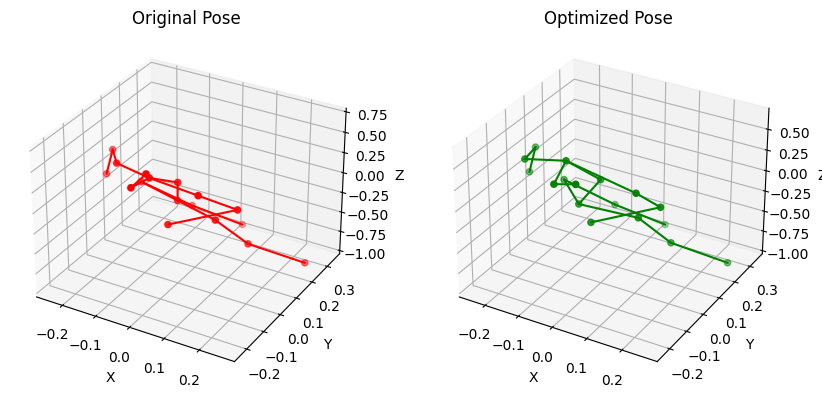

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def visualize_poses_in_video(original_pose, optimized_pose):
    # Number of frames
    num_frames = original_pose.shape[0]

    # Define pairs of keypoints to connect
    pairs = [(0, 1), (0, 4), (0, 7), (7, 8), (8, 9), (9, 10), (4, 5), (1, 2), (5, 6), (2, 3),
             (8, 11), (8, 14), (11, 12), (14, 15), (12, 13), (15, 16)]

    # Initialize plot with two subplots
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Function to update each frame in the animation
    def update_graph(num, original_pose, optimized_pose, pairs):
        ax1.clear()
        ax2.clear()

        # Plot for original pose in red
        x, y, z = original_pose[num, :, 0], original_pose[num, :, 2], -original_pose[num, :, 1]
        ax1.scatter(x, y, z, color='red')
        for pair in pairs:
            ax1.plot([x[pair[0]], x[pair[1]]], [y[pair[0]], y[pair[1]]], [z[pair[0]], z[pair[1]]], color='red')
        ax1.set_title('Original Pose')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')

        # Plot for optimized pose in green
        x, y, z = optimized_pose[num, :, 0], optimized_pose[num, :, 2], -optimized_pose[num, :, 1]
        ax2.scatter(x, y, z, color='green')
        for pair in pairs:
            ax2.plot([x[pair[0]], x[pair[1]]], [y[pair[0]], y[pair[1]]], [z[pair[0]], z[pair[1]]], color='green')
        ax2.set_title('Optimized Pose')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')

        return fig,

    # Create animation
    ani = animation.FuncAnimation(fig, update_graph, fargs=(original_pose, optimized_pose, pairs),
                                  frames=num_frames, interval=100, blit=False)

    # Save the animation as a video
    ani.save('poses_comparison.mp4', writer='ffmpeg', fps=10)
visualize_poses_in_video(data_3d, optimized_pose)

In [12]:
optimized_pose.shape

(168, 17, 3)

In [ ]:
data_3d[1,:16,:]

In [ ]:
import plotly.graph_objects as go
import webbrowser
import time

def visualize_frame(frame):
    # Extract x, y, z coordinates of keypoints
    x = frame[:, 0]
    y = frame[:, 2]
    z = - frame[:, 1]

    # Create a scatter plot for the keypoints
    scatter = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(size=5, color='red')
    )

    # Define pairs of keypoints to connect with green lines
    pairs = [(0,1), (0,4), (0,7), (7,8), (8,9), (9,10), (4,5), (1,2), (5,6), (2,3),
             (8,11), (8,14), (11,12), (14,15), (12,13), (15,16)]

    lines = []
    for pair in pairs:
        lines.append(
            go.Scatter3d(
                x=[x[pair[0]], x[pair[1]]],
                y=[y[pair[0]], y[pair[1]]],
                z=[z[pair[0]], z[pair[1]]],
                mode='lines',
                line=dict(color='green', width=5)
            )
        )

    # Create the layout and add all traces
    layout = go.Layout(
        scene=dict(
            xaxis=dict(nticks=10, range=[min(x), max(x)]),
            yaxis=dict(nticks=10, range=[min(y), max(y)]),
            zaxis=dict(nticks=10, range=[min(z), max(z)])
        )
    )

    fig = go.Figure(data=[scatter] + lines, layout=layout)

    # Save the plot as an HTML file
    filename = "plot.html"
    fig.write_html(filename)

    # Open the saved HTML file in the default web browser
    webbrowser.open(filename)
    time.sleep(3)


for frame in optimized_pose:
    visualize_frame(frame)

In [ ]:
!pip install pandas

In [ ]:
type(data_3d)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom function
def custom_function(x):
    if x <= 10:
        return 0
    elif 10 < x <= 20:
        return (x - 10) / 10  # Linear increase from 0 to 1
    elif 20 < x <= 40:
        return 1 + (x - 20) / 20  # Linear increase from 1 to 2
    else:
        return 2

# Generate a range of values for x
x_values = np.linspace(-np.inf, 50, 400)
y_values = [custom_function(x) if x != -np.inf else 0 for x in x_values]

# Plotting the function
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label="Custom Function")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Custom Function Plot')
plt.axhline(y=0, color='k',linewidth=0.5)
plt.axhline(y=1, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=2, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=10, color='r', linestyle='--', linewidth=0.5)
plt.axvline(x=20, color='r', linestyle='--', linewidth=0.5)
plt.axvline(x=40, color='r', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()